## Import requirements

In [1]:

from transformers import AutoModel, AutoTokenizer
from models.ImageEncoderClass import ImageEncoder
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms import functional as F
import os
from utils.helpers import preprocess_image, tokenize_text
import torch
import numpy as np
import torch.nn.functional as F
from dataset.dataset_getter import get_fashion_product_data

C:\Users\vince\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset download

In [2]:
PATH_TO_IMAGES = "./data/"
dataset = get_fashion_product_data(PATH_TO_IMAGES)

## Input parameters
We chose to take 4 arbitrary images because we did not have time to train the model on the whole dataset

In [14]:
original_images = []
images = []
texts = []
descriptions = {
    "1164.jpg": "A blue football shirt",
    "1541.jpg": "A sport shoe (sneacker) that is white and green",
    "59993.jpg": "A white woman wearing a long black dress whithout stockings",
    "57604.jpg": "A red golden lipstick that is open",
}
input_ids = []
attention_masks = []

PATH_TO_IMAGES = "./data/images"
model_name = "huawei-noah/TinyBERT_General_4L_312D"

## Models loading (using pretrained models and custom ImageEncoder class)

In [4]:
img_model = ImageEncoder()
tokenizer = AutoTokenizer.from_pretrained(model_name)
txt_model = AutoModel.from_pretrained(model_name, output_attentions=False)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 

## Features and Similarities computing

In [15]:
for filename in [filename for filename in os.listdir(PATH_TO_IMAGES)]:
    if filename not in list(descriptions.keys()):
        continue
    image = Image.open(os.path.join(PATH_TO_IMAGES, filename)).convert("RGB")
    images.append(preprocess_image(image))
    original_images.append(image)
    current_tokenized_text = tokenize_text(descriptions[filename], tokenizer=tokenizer)
    input_ids.append(current_tokenized_text["input_ids"])
    attention_masks.append(current_tokenized_text["attention_mask"])
images_input = torch.tensor(np.stack(images))
texts_input = texts

with torch.no_grad():
    img_features = img_model(images_input)

    similarities = np.zeros((len(original_images), len(descriptions)))
    for i, image in enumerate(original_images):
        for j, text in enumerate(list(descriptions.values())):
            txt_features = txt_model(input_ids[j], attention_mask=attention_masks[j]).last_hidden_state[:, 0, :]
            similarity = F.cosine_similarity(img_features[i], txt_features[0], dim=0)
            similarities[i][j] = similarity.item()

## Plotting
Plot a matrix using similarity scores between images and texts

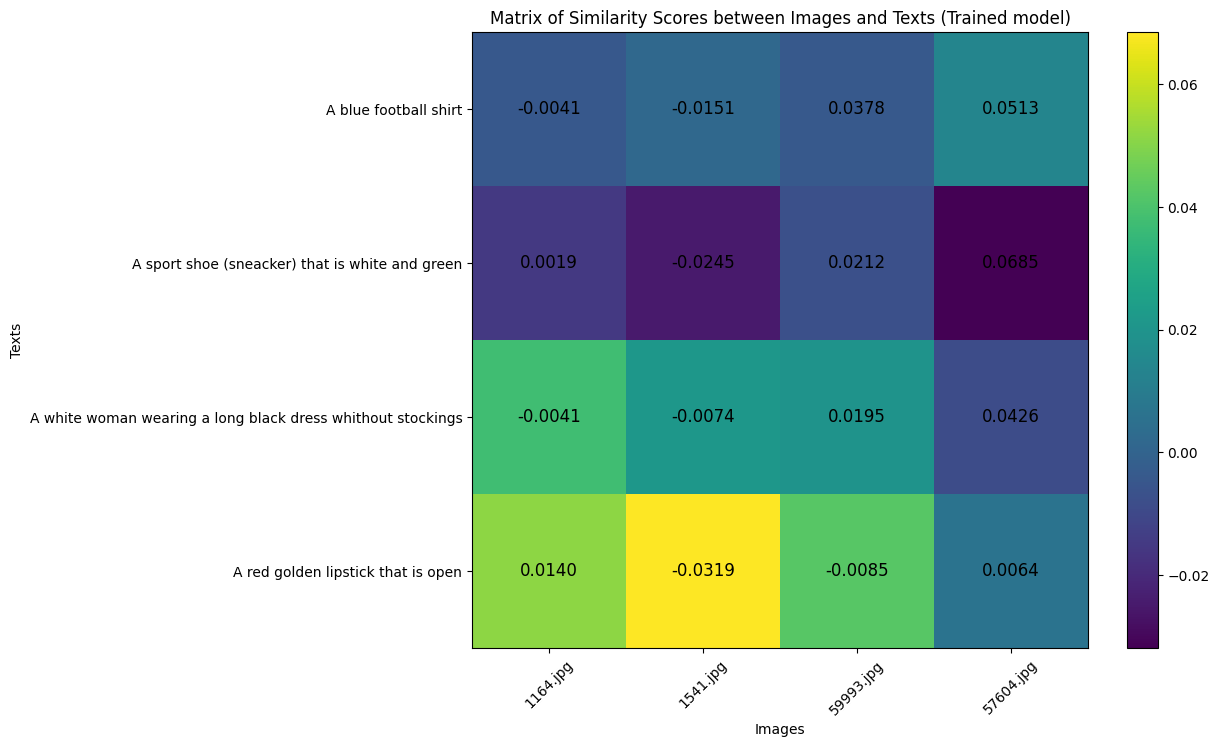

In [17]:
count = len(original_images)

plt.figure(figsize=(10, 8))
plt.imshow(similarities, cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.xticks(range(count), list(descriptions.keys()), rotation=45)
plt.yticks(range(count), list(descriptions.values()))
plt.xlabel("Images")
plt.ylabel("Texts")
plt.title("Matrix of Similarity Scores between Images and Texts (Trained model)")
for i, image in enumerate(original_images):
    for j, text in enumerate(list(descriptions.values())):
        plt.text(i, j, f"{similarities[i][j]:.4f}", ha="center", va="center", size=12)
plt.show()

## Testing Stuff

In [7]:
from train.train import train_and_eval_clip
import pandas as pd


if __name__ == "__main__":
    csv_path = "./data/styles.csv"
    df = pd.read_csv(csv_path, delimiter=',', quotechar='"', encoding='utf-8', usecols=['id', 'productDisplayName'])
    df = df[df['id'].apply(lambda x: os.path.isfile(os.path.join(PATH_TO_IMAGES, f"{x}.jpg")))]
    df['productDisplayName'] = df['productDisplayName'].str.replace(r',$', '', regex=True)
    descriptions = {str(row['id']) + ".jpg": row['productDisplayName'] for _, row in df.iterrows()}
    image_model, text_model = train_and_eval_clip("./data/images", descriptions)

Train size: 44, Test size: 4


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

Epoch 1/1, Loss: 0.004586740566553015
Validation Loss: 1.5341432094573975
